In [1]:
import os
os.chdir('/content/drive/Shared drives/Unlimiteddrive/unet_keras/')

In [65]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import (Input, BatchNormalization, Activation, Dense, Dropout, 
                                     Lambda, RepeatVector, Reshape, Conv2D, Conv2DTranspose, 
                                     MaxPooling2D, GlobalMaxPool2D, concatenate, add)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

In [66]:
w, h = 304,304
border = 5 

In [67]:
ids = next(os.walk("./data/train/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  64


# **Data Reading and Train test split**

In [5]:
import glob
train = sorted(glob.glob("./data/train/*"))
train_mask = sorted(glob.glob("./data/trainlabel/*.png"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 64
Total Mask Image : 64


In [6]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [7]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

In [10]:
print(X.shape, y.shape)

(64, 304, 304, 3) (64, 304, 304, 1)


In [11]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(57, 304, 304, 3) (57, 304, 304, 1) (7, 304, 304, 3) (7, 304, 304, 1)


# **Visualization the image and It masks**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


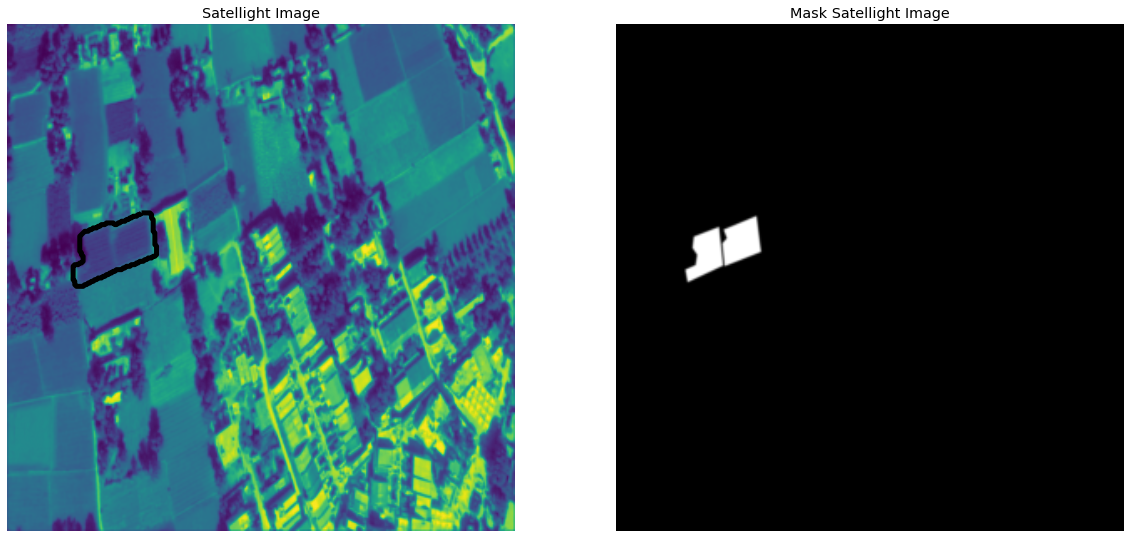

In [12]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  ''' Function to add 2 Convolution Layers with parameters passed to it '''
  # First Layer
  x  = Conv2D(filters = n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding = 'same')(input_tensor)

  if batchnorm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Second Layer
  x  = Conv2D(filters = n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding = 'same')(input_tensor)

  if batchnorm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [21]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [32]:
smooth = 1.
def dice_coef(y_true, y_pred):
    """Generate the 'Dice' coefficient for the provided prediction.
    Args:
        y_true: The expected/desired output mask.
        y_pred: The actual/predicted mask.
    Returns:
        The Dice coefficient between the expected and actual outputs. Values
        closer to 1 are considered 'better'.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    """Model loss function using the 'Dice' coefficient.
    Args:
        y_true: The expected/desired output mask.
        y_pred: The actual/predicted mask.
    Returns:
        The corresponding loss, related to the dice coefficient between the expected
        and actual outputs. Values closer to 0 are considered 'better'.
    """
    return -dice_coef(y_true, y_pred)


In [33]:
input_img = Input((h, w, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", dice_coef])

In [28]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 304, 304, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 304, 304, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 304, 304, 16) 64          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 304, 304, 16) 0           batch_normalization_37[0][0]     
_______________________________________________________________________________________

In [34]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-satellight-image.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='./logs')
]

In [35]:
results = model.fit(dataset, batch_size=6, epochs=50, callbacks=callbacks, validation_data=valset, use_multiprocessing=True)

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.9773 - accuracy: 0.3671 - dice_coef: 0.0127WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1052s vs `on_train_batch_end` time: 0.2699s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.93042, saving model to model-satellight-image.h5
2/2 [==============================] - 2s 874ms/step - loss: 0.9773 - accuracy: 0.3671 - dice_coef: 0.0127 - val_loss: 0.9304 - val_accuracy: 0.2375 - val_dice_coef: 0.0140
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.8874 - accuracy: 0.2830 - dice_coef: 0.0139
Epoch 00002: val_loss did not improve from 0.93042
2/2 [==============================] - 0s 113ms/step - loss: 0.8874 - accuracy: 0.2830 - dice_coef: 0.0139 - val_loss: 1.6549 - val_accuracy: 0.2756 - val_dice_coef: 0.0141
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.8143 - accuracy: 0.2959 - dice_coef: 0.014

In [40]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('dice_coef', ascending=False, inplace = True)
df_result

,loss,accuracy,dice_coef,val_loss,val_accuracy,val_dice_coef,lr
2,0.814313,0.295866,0.014307,7.640218,0.191321,0.014339,0.0010
3,0.745444,0.378471,0.014299,25.269299,0.067317,0.014391,0.0010
4,0.679798,0.522185,0.014106,36.473370,0.007095,0.014423,0.0010
5,0.617852,0.693111,0.013894,101.862289,0.005369,0.014414,0.0010
1,0.887434,0.283045,0.013865,1.654905,0.275558,0.014099,0.0010
6,0.575593,0.805131,0.013746,70.934975,0.005766,0.014418,0.0001
7,0.570677,0.814420,0.013727,46.965096,0.006233,0.014423,0.0001
8,0.565453,0.822935,0.013712,31.861805,0.006497,0.014427,0.0001
9,0.559943,0.832542,0.013678,23.398966,0.006990,0.014425,0.0001
10,0.554484,0.843040,0.013647,17.442289,0.008202,0.014413,0.0001


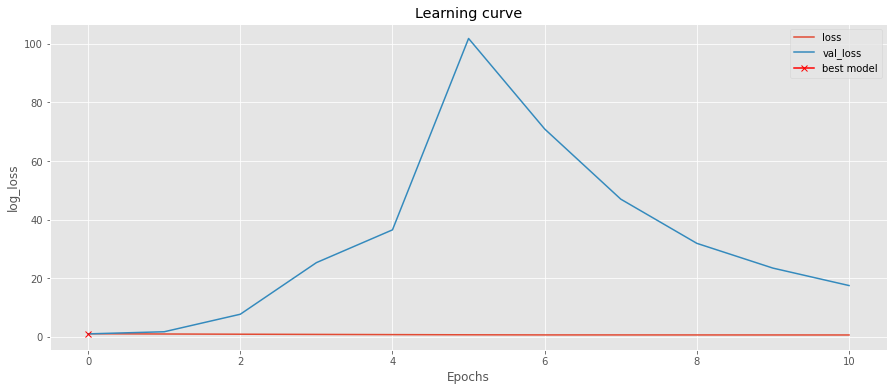

In [44]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# **Inference**

In [45]:
model.load_weights('model-satellight-image.h5')

In [46]:
model.evaluate(valset, verbose=1)

1/1 [==============================] - 0s 5ms/step - loss: 0.9304 - accuracy: 0.2375 - dice_coef: 0.0140


[0.9304171204566956, 0.23746506869792938, 0.014003673568367958]

In [47]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 12ms/step


In [48]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [57]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

# **Predictions on training set**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


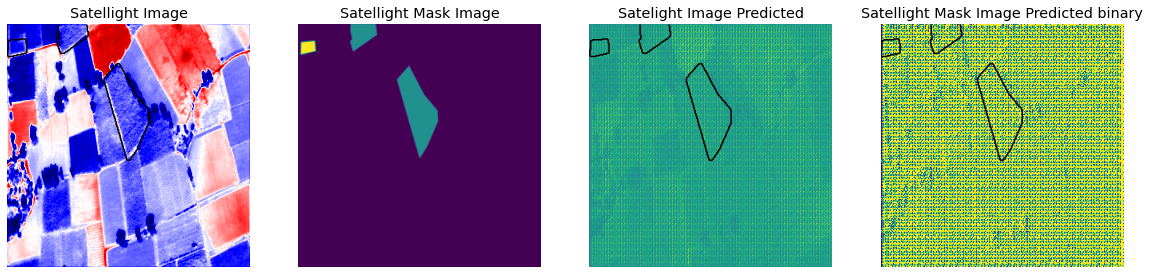

In [58]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


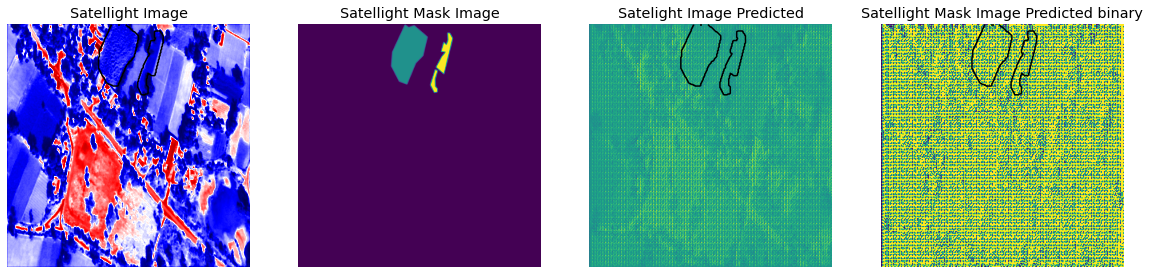

In [59]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


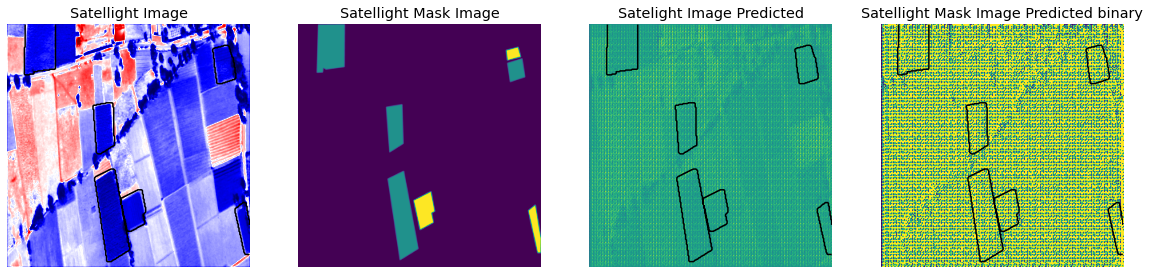

In [60]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


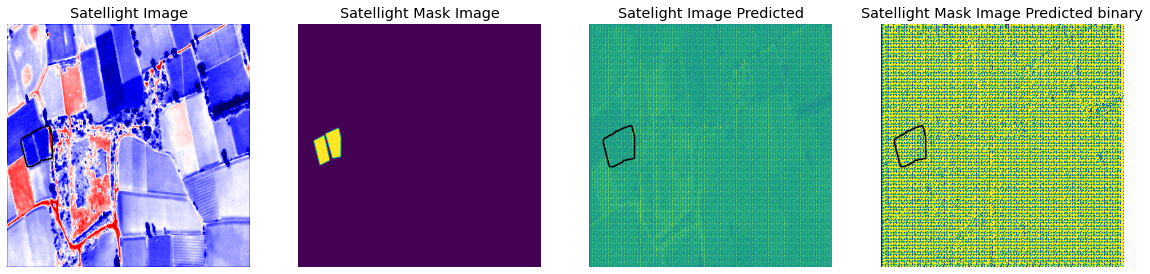

In [61]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


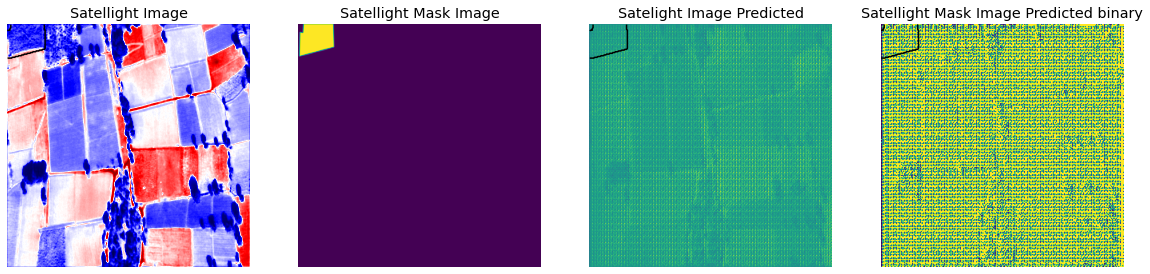

In [62]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


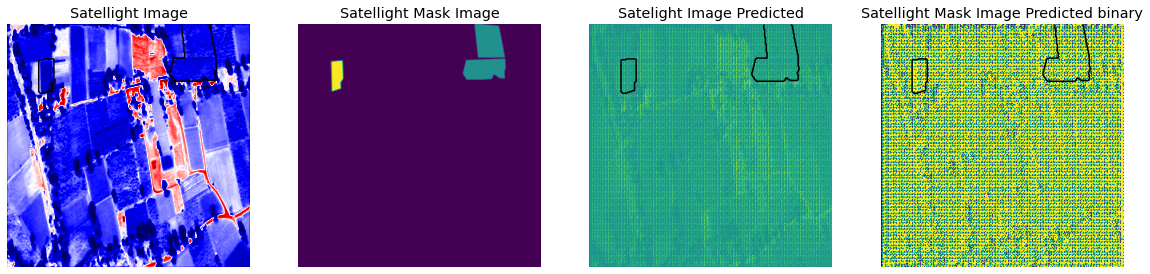

In [64]:
plot_sample(X_train, y_train, preds_train, preds_train_t)